# Chapter 4 - Classification

- [Load dataset](#Load-dataset)
- [The Default data set](#Figure-4.1---Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
- [Lab: 4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
- [Lab: 4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
- [Lab: 4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [Lab: 4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf


##### Load dataset

In [14]:

# Install openpyxl
df = pd.read_excel('data/Default.xlsx')

# factorize() encodes the variable as a categorical variable
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

/Users/tz89p/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0


#### 4.3 Logistic Regression

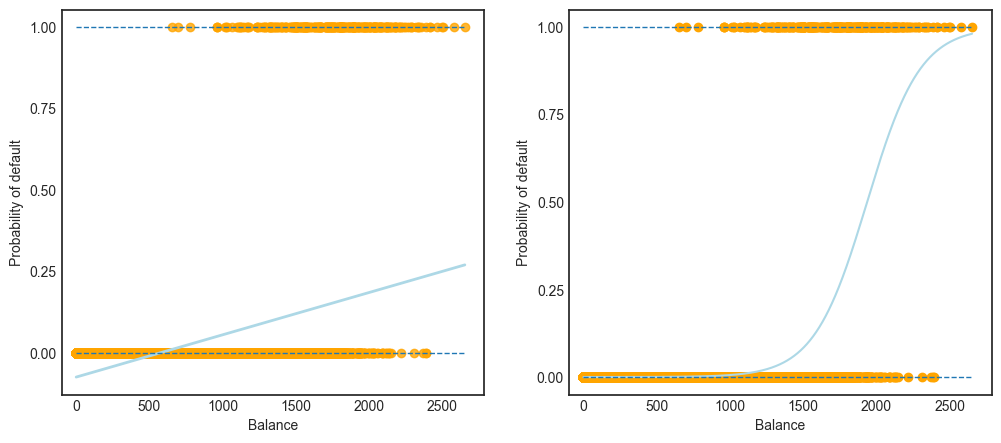

In [22]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test) ## return the probability of the classes (n, n_classes)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(data=df, x='balance', y='default2', order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

#####  scikit-learn

In [24]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
y = df.default2
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.00549891]]
intercept : [-10.6513227]


##### statsmodels

In [26]:
est = smf.logit('default2 ~ balance', df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [29]:
est = smf.logit('default2 ~ student2', df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


##### Multiple Logistic Regression

In [31]:
est = smf.logit('default2 ~ balance + income + student2', df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


##### Confounding

In [33]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(-1, 1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(-1, 1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [34]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


/Users/tz89p/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tz89p/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tz89p/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='student', ylabel='balance'>

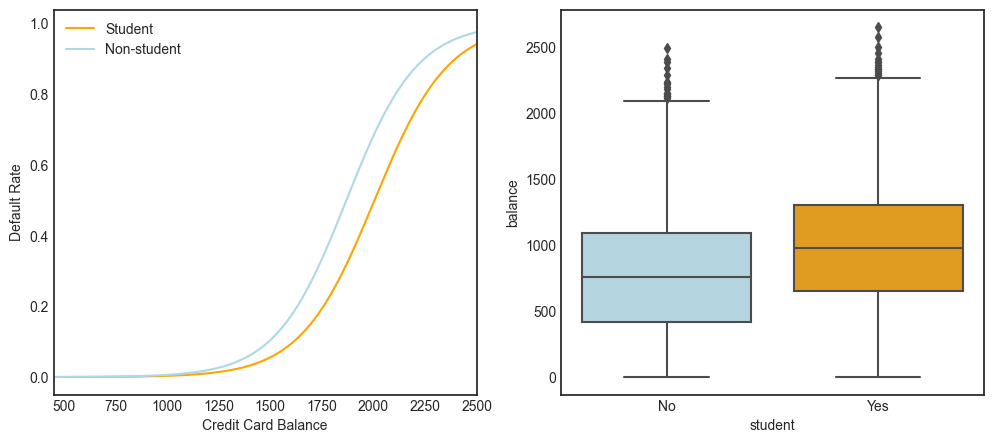

In [37]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')

ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot(x='student', y='balance', data=df, orient='v', ax=ax2,  palette=c_palette)

#### 4.4 Linear Discriminant Analysis


In [40]:
X = df[['balance', 'income', 'student2']].to_numpy()
y = df.default2.to_numpy()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [65]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000




Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'. 

In [41]:
df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [46]:
## Because many Yes samples are predicted as No
decision_prob = 0.25
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
False,9518,164
True,149,169


##### 4.6.3 Linear Discriminant Analysis

In [47]:
df = pd.read_csv('data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)

In [60]:
## divide the dataset into train and validation sets
## Daily percentage returns for the S&P 500 stock
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

print(y_test)

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

Year
2005-01-01    Down
2005-01-01    Down
2005-01-01    Down
2005-01-01      Up
2005-01-01    Down
              ... 
2005-01-01      Up
2005-01-01    Down
2005-01-01      Up
2005-01-01    Down
2005-01-01    Down
Name: Direction, Length: 252, dtype: object


In [61]:
lda.priors_

array([0.49198397, 0.50801603])

In [62]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [64]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down       0.50      0.32      0.39       111
          Up       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252



##### 4.6.4 Quadratic Discriminant Analysis

In [72]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

['Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Down' 'Down'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down'
 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Down' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down' 'Down' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Down' 'Down' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 

In [67]:
qda.priors_

array([0.49198397, 0.50801603])

In [68]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [69]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



##### 4.6.5 K-Nearest Neighbors

In [70]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



In [71]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252

